In [26]:
from langgraph.graph import StateGraph,START, END
from typing import TypedDict,Literal,Annotated
from dotenv import load_dotenv
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import SystemMessage, HumanMessage

In [27]:
load_dotenv()

True

In [28]:
generator_llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    temperature=0.7,  
)

evaluator_llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    temperature=0.0,   
)

optimizer_llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    temperature=0.3,  
)


In [29]:
from pydantic import BaseModel, Field
class tweetevaluation(BaseModel):
    evaluation: Literal['approved', 'needs improvement'] = Field(..., description="The evaluation of the tweet")
    feedback: str = Field(..., description="Feedback for improvement if needed")

In [30]:
structured_evalator=evaluator_llm.with_structured_output(tweetevaluation)


In [31]:
class tweet(TypedDict):
    topic: str
    tweet: str
    evaluation: Literal['approved', 'needs improvement']
    feedback: str
    iteration:int
    max_iteration:int
    

In [37]:
def generate_tweet(state:tweet):
    messages=[
        SystemMessage(content="You are a creative social media content generator."),
        HumanMessage(content=f"Create a tweet about the topic: {state['topic']}.")
    ]
    response = generator_llm.invoke(messages)

    return {
        'tweet':response.content,
    }
def evaluate_tweet(state:tweet):
    messages=[
        SystemMessage(content="You are a meticulous social media content evaluator."),
        HumanMessage(content=f"Evaluate the following tweet for quality and engagement: {state['tweet']}. Provide feedback and indicate if it is 'approved' or 'needs improvement'.")
    ]
    response = structured_evalator.invoke(messages)
    return {
        'evaluation':response.evaluation,
        'feedback':response.feedback,
    }
def optimize_tweet(state:tweet):
    messages=[
        SystemMessage(content="You are a creative social media content optimizer."),
        HumanMessage(content=f"Improve the following tweet based on this feedback: {state['feedback']}. Tweet: {state['tweet']}.")
    ]
    response = optimizer_llm.invoke(messages)
    iteration=state['iteration']+1
    return {
        'tweet':response.content,
        'iteration':iteration,
    }


In [33]:
def route_evaluation(state:tweet):
    if state['evaluation']=='approved' or state['iteration']>=state['max_iteration']:
        return 'approve'
    else:
        return 'optimize'

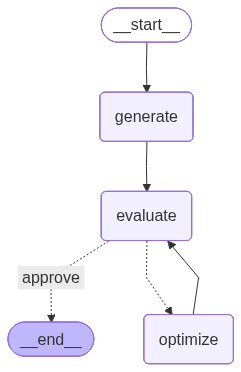

In [38]:
graph=StateGraph(tweet)
graph.add_node('generate', generate_tweet)
graph.add_node('evaluate', evaluate_tweet)
graph.add_node('optimize', optimize_tweet)
graph.add_edge(START, 'generate')
graph.add_edge('generate', 'evaluate')
graph.add_conditional_edges('evaluate', route_evaluation,{'approve':END,'optimize':'optimize'})
graph.add_edge('optimize', 'evaluate')
graph.compile()


In [39]:
workflow=graph.compile()

In [40]:
workflow.invoke({
    'topic':'The future of AI in healthcare',
    'iteration':1,
    'max_iteration':3
})

{'topic': 'The future of AI in healthcare',
 'tweet': "Here are a few options, choose the one that best fits your brand's tone!\n\n**Option 1 (Optimistic & Engaging):**\nThe future of healthcare is here, powered by AI! 🤖 Imagine personalized treatments, lightning-fast diagnoses & groundbreaking drug discoveries. What role do you see AI playing in shaping healthier lives for all? Let's discuss! 👇\n#AIinHealthcare #FutureofMedicine #HealthTech #Innovation\n\n**Option 2 (Benefit-Focused):**\nFrom predicting diseases to optimizing drug development, AI is set to revolutionize healthcare. Get ready for a smarter, more personalized approach to well-being! ✨\n#AI #HealthcareInnovation #MedTech #DigitalHealth\n\n**Option 3 (Question-Based & Thought-Provoking):**\nHow will AI transform your next doctor's visit? The future of healthcare is moving towards precision, prevention, and personalization thanks to intelligent tech. What advancements are you most excited to see?\n#AIinHealth #FutureIsNow 